In [1]:
# default_exp datasets

# Simulated Datasets
The approach for creating simulated datasets is to initialize a model with specified parameters and experience sequences and then populate a psifr-formatted array with the outcomes of performing `free recall`. 

The `simulate_data` function below presumes each item is just presented once and that a model has already been initialized, and is better for quick baseline characterization of model performance. Datasets with item repetitions during presentation violate this premise; a more unique function is normally necessary for simulating these models in a performant way.

Since model simulation this way has always directly led to visualization in work done so far, a corresponding `trials` array is not produced.

In [1]:
# export
import pandas as pd
from psifr import fr
import numpy as np
from numba import int32
from numba import njit
int32 = int

def simulate_df(model, experiment_count, first_recall_item=None):
    """
    Initialize a model with specified parameters and experience sequences and 
    then populate a psifr-formatted dataframe with the outcomes of performing `free recall`. 
    
    **Required model attributes**:
    - item_count: specifies number of items encoded into memory
    - context: vector representing an internal contextual state
    - experience: adding a new trace to the memory model
    - free_recall: function that freely recalls a given number of items or until recall stops
    """
    
    # encode items
    model.experience(model.items)

    # simulate retrieval for the specified number of times, tracking results in df
    data = []
    for experiment in range(experiment_count):
        data += [[experiment, 0, 'study', i + 1, i] for i in range(model.item_count)]
    for experiment in range(experiment_count):
        if first_recall_item is not None:
            model.force_recall(first_recall_item)
        data += [[experiment, 0, 'recall', i + 1, o] for i, o in enumerate(model.free_recall())]
    data = pd.DataFrame(data, columns=['subject', 'list', 'trial_type', 'position', 'item'])
    merged = fr.merge_free_recall(data)
    
    return merged

simulate_data = simulate_df

In [2]:
# export

#@njit(fastmath=True, nogil=True)
def simulate_array_from_presentations(model_class, parameters, presentations, experiment_count):

    # simulate retrieval for the specified number of times, tracking results in array
    trials = np.zeros((experiment_count * len(presentations), np.max(presentations)+1), dtype=int32)
    
    for experiment in range(experiment_count):
        for trial_index in range(len(presentations)):
        
            presentation = presentations[trial_index]
            item_count = np.max(presentation)+1
            model = model_class(item_count, len(presentation), parameters)
            model.experience(model.items[presentation])

            # simulate recall and identify first study position of each recalled item
            recalled = model.free_recall()

            # start with indices that would sort the presentation vector
            # presentation[xsorted] is a sorted presentation vector!
            xsorted = np.argsort(presentation) 

            # Find the indices into a sorted array a such that, 
            # if the corresponding elements in v were inserted before the indices, 
            # the order of a would be preserved.
            # since presentation contains all possible recalls and each recall is unique,
            # this gets us the sorted index of each recalled item in presentation
            # well, not the sorted index - that's xsorted! but the item ind
            ypos = np.searchsorted(presentation[xsorted], recalled)
            study_positions_in_recall_order = xsorted[ypos]+1
            trials[experiment*len(presentations) + trial_index, 
                   :len(recalled)] = study_positions_in_recall_order

    return trials

In [3]:
# export

#@njit(fastmath=True, nogil=True)
def simulate_array(model, experiment_count, first_recall_item=None):
    
    # encode items
    model.experience(model.items)

    # simulate retrieval for the specified number of times, tracking results in array
    trials = np.zeros((experiment_count, len(model.items)), dtype=int32)
    
    for trial_index in range(len(trials)):
        
        recalled = model.free_recall()
        trials[trial_index, :len(recalled)] = recalled + 1
        
    return trials

In [4]:
from compmemlearn.models import Classic_CMR
from compmemlearn.datasets import prepare_murdock1970_data, prepare_lohnas2014_data
from compmemlearn.analyses import recall_probability_by_lag, fast_spc
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

murd_trials0, murd_events0, murd_length0 = prepare_murdock1970_data('../../data/mo1970.txt')

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

cmr_result = np.array(
    [5.84259066e-01, 4.27375824e-03, 7.21454638e-01, 8.17704509e-01,
     1.00000000e+00, 9.88623591e-02, 9.31571732e+00, 7.54040329e+01,
     3.14204629e-02, 3.36598109e-01, 9.99452206e+00, 9.95457387e-01])

fitted_parameters = Dict.empty(
    key_type=types.unicode_type, value_type=types.float64)
for i in range(len(cmr_result)):
    fitted_parameters[cmr_free_parameters[i]] = cmr_result[i]
fitted_parameters['sampling_rule'] = 0
fitted_parameters['mfc_familiarity_scale'] = 0
fitted_parameters['mcf_familiarity_scale'] = 0
fitted_parameters['drift_familiarity_scale'] = 0

model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)

sim_df = simulate_data(model, 1000)

sim_df.head()

,subject,list,item,input,output,study,recall,repeat,intrusion
0,0,0,0,1,NaN,True,False,0,False
1,0,0,1,2,7.0,True,True,0,False
2,0,0,2,3,NaN,True,False,0,False
3,0,0,3,4,5.0,True,True,0,False
4,0,0,4,5,NaN,True,False,0,False


In [5]:
model = Classic_CMR(murd_length0, murd_length0, fitted_parameters)
original_sim_array = simulate_array(model, len(murd_trials0))
original_spc = fast_spc(original_sim_array, murd_length0)

presentations = np.zeros((len(murd_trials0), murd_length0), dtype=int)
presentations[:] = np.arange(murd_length0)

@njit(nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

new_sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, np.flip(presentations, axis=1), 1)
new_spc = fast_spc(new_sim_array, murd_length0)

In [28]:
original_sim_array, new_sim_array

(array([[16, 20,  7, ...,  0,  0,  0],
        [20,  6, 19, ...,  0,  0,  0],
        [20, 17, 18, ...,  0,  0,  0],
        ...,
        [20,  4, 17, ...,  0,  0,  0],
        [19, 20, 17, ...,  0,  0,  0],
        [ 1,  2, 11, ...,  0,  0,  0]]),
 array([[ 3,  1,  5, ...,  0,  0,  0],
        [19, 20, 13, ...,  0,  0,  0],
        [17, 19, 20, ...,  0,  0,  0],
        ...,
        [ 1,  4,  5, ...,  0,  0,  0],
        [10, 12, 16, ...,  0,  0,  0],
        [20,  7,  0, ...,  0,  0,  0]]))

In [29]:
original_spc, new_spc

(array([0.33680556, 0.15486111, 0.17222222, 0.15416667, 0.17291667,
        0.20416667, 0.19236111, 0.21180556, 0.22986111, 0.23333333,
        0.23263889, 0.25069444, 0.26388889, 0.26944444, 0.30069444,
        0.32083333, 0.39791667, 0.43888889, 0.54375   , 0.68819444]),
 array([0.33333333, 0.15833333, 0.17847222, 0.17708333, 0.19791667,
        0.19791667, 0.20208333, 0.20555556, 0.20555556, 0.21875   ,
        0.22222222, 0.24444444, 0.24791667, 0.27847222, 0.3125    ,
        0.34305556, 0.37013889, 0.4375    , 0.51111111, 0.65069444]))

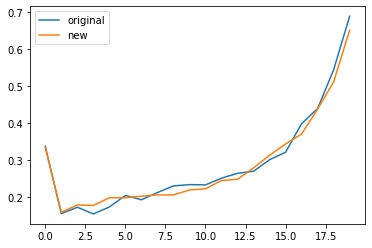

In [30]:
import matplotlib.pyplot as plt

plt.plot(fast_spc(original_sim_array, murd_length0), label='original')
plt.plot(fast_spc(new_sim_array, murd_length0), label='new')

plt.legend()

In [6]:
trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

new_sim_array = simulate_array_from_presentations(init_cmr, fitted_parameters, presentations, 100)

KeyboardInterrupt: 

In [9]:
trials[0]

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 17, 14, 12, 15, 25, 20, 28,
       30, 39, 38, 37, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])